In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Instalar las librerías necesarias
%pip install requests
%pip install kneed


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [95]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import requests
from io import StringIO
%pip install kneed
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FactorAnalysis


Note: you may need to restart the kernel to use updated packages.


# Lectura del dataset
Utilizaremos el conjunto de datos de calidad del vino. Este conjunto de datos contiene varias propiedades químicas del vino, como la acidez, el azúcar, el pH y el alcohol. También contiene una métrica de calidad (3-9, siendo mejor la más alta) y un color (rojo o blanco).

In [4]:
# URL del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/osiris-contreras/Osiris-Contreras-Trillos-/main/Wine_Quality_Data.csv'

# Obtener los datos del archivo CSV
response = requests.get(url)
csv_data = response.content.decode('utf-8')

# Leer los datos del archivo CSV utilizando pandas
df = pd.read_csv(StringIO(csv_data))

# Mostrar las primeras filas del DataFrame
df.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2      9.8        5   red  
3      9.8        6   red  
4      9.4        5   red

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [6]:
df.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6497.000000  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801     5.818378  
std       0.160787     0.148806     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

In [7]:
# Descripción estadística general de las variables categóricas
df.describe(include=['object'])

color
count    6497
unique      2
top     white
freq     4898

In [8]:
# Comprobación de valores duplicados
df.duplicated().sum()

1177

In [9]:
# Eliminación de valores duplicados
df2 = df.drop_duplicates()

# Comprobación de valores duplicados
df2.duplicated().sum()
df2.shape

(5320, 13)

## análisis exploratorio de los datos

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         5320 non-null   float64
 1   volatile_acidity      5320 non-null   float64
 2   citric_acid           5320 non-null   float64
 3   residual_sugar        5320 non-null   float64
 4   chlorides             5320 non-null   float64
 5   free_sulfur_dioxide   5320 non-null   float64
 6   total_sulfur_dioxide  5320 non-null   float64
 7   density               5320 non-null   float64
 8   pH                    5320 non-null   float64
 9   sulphates             5320 non-null   float64
 10  alcohol               5320 non-null   float64
 11  quality               5320 non-null   int64  
 12  color                 5320 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 581.9+ KB


In [10]:
# Descripción estadística general de las variables categóricas
df2.describe(include=['object'])

color
count    5320
unique      2
top     white
freq     3961

In [11]:
float_columns = [x for x in df2.columns if x not in ['color']]

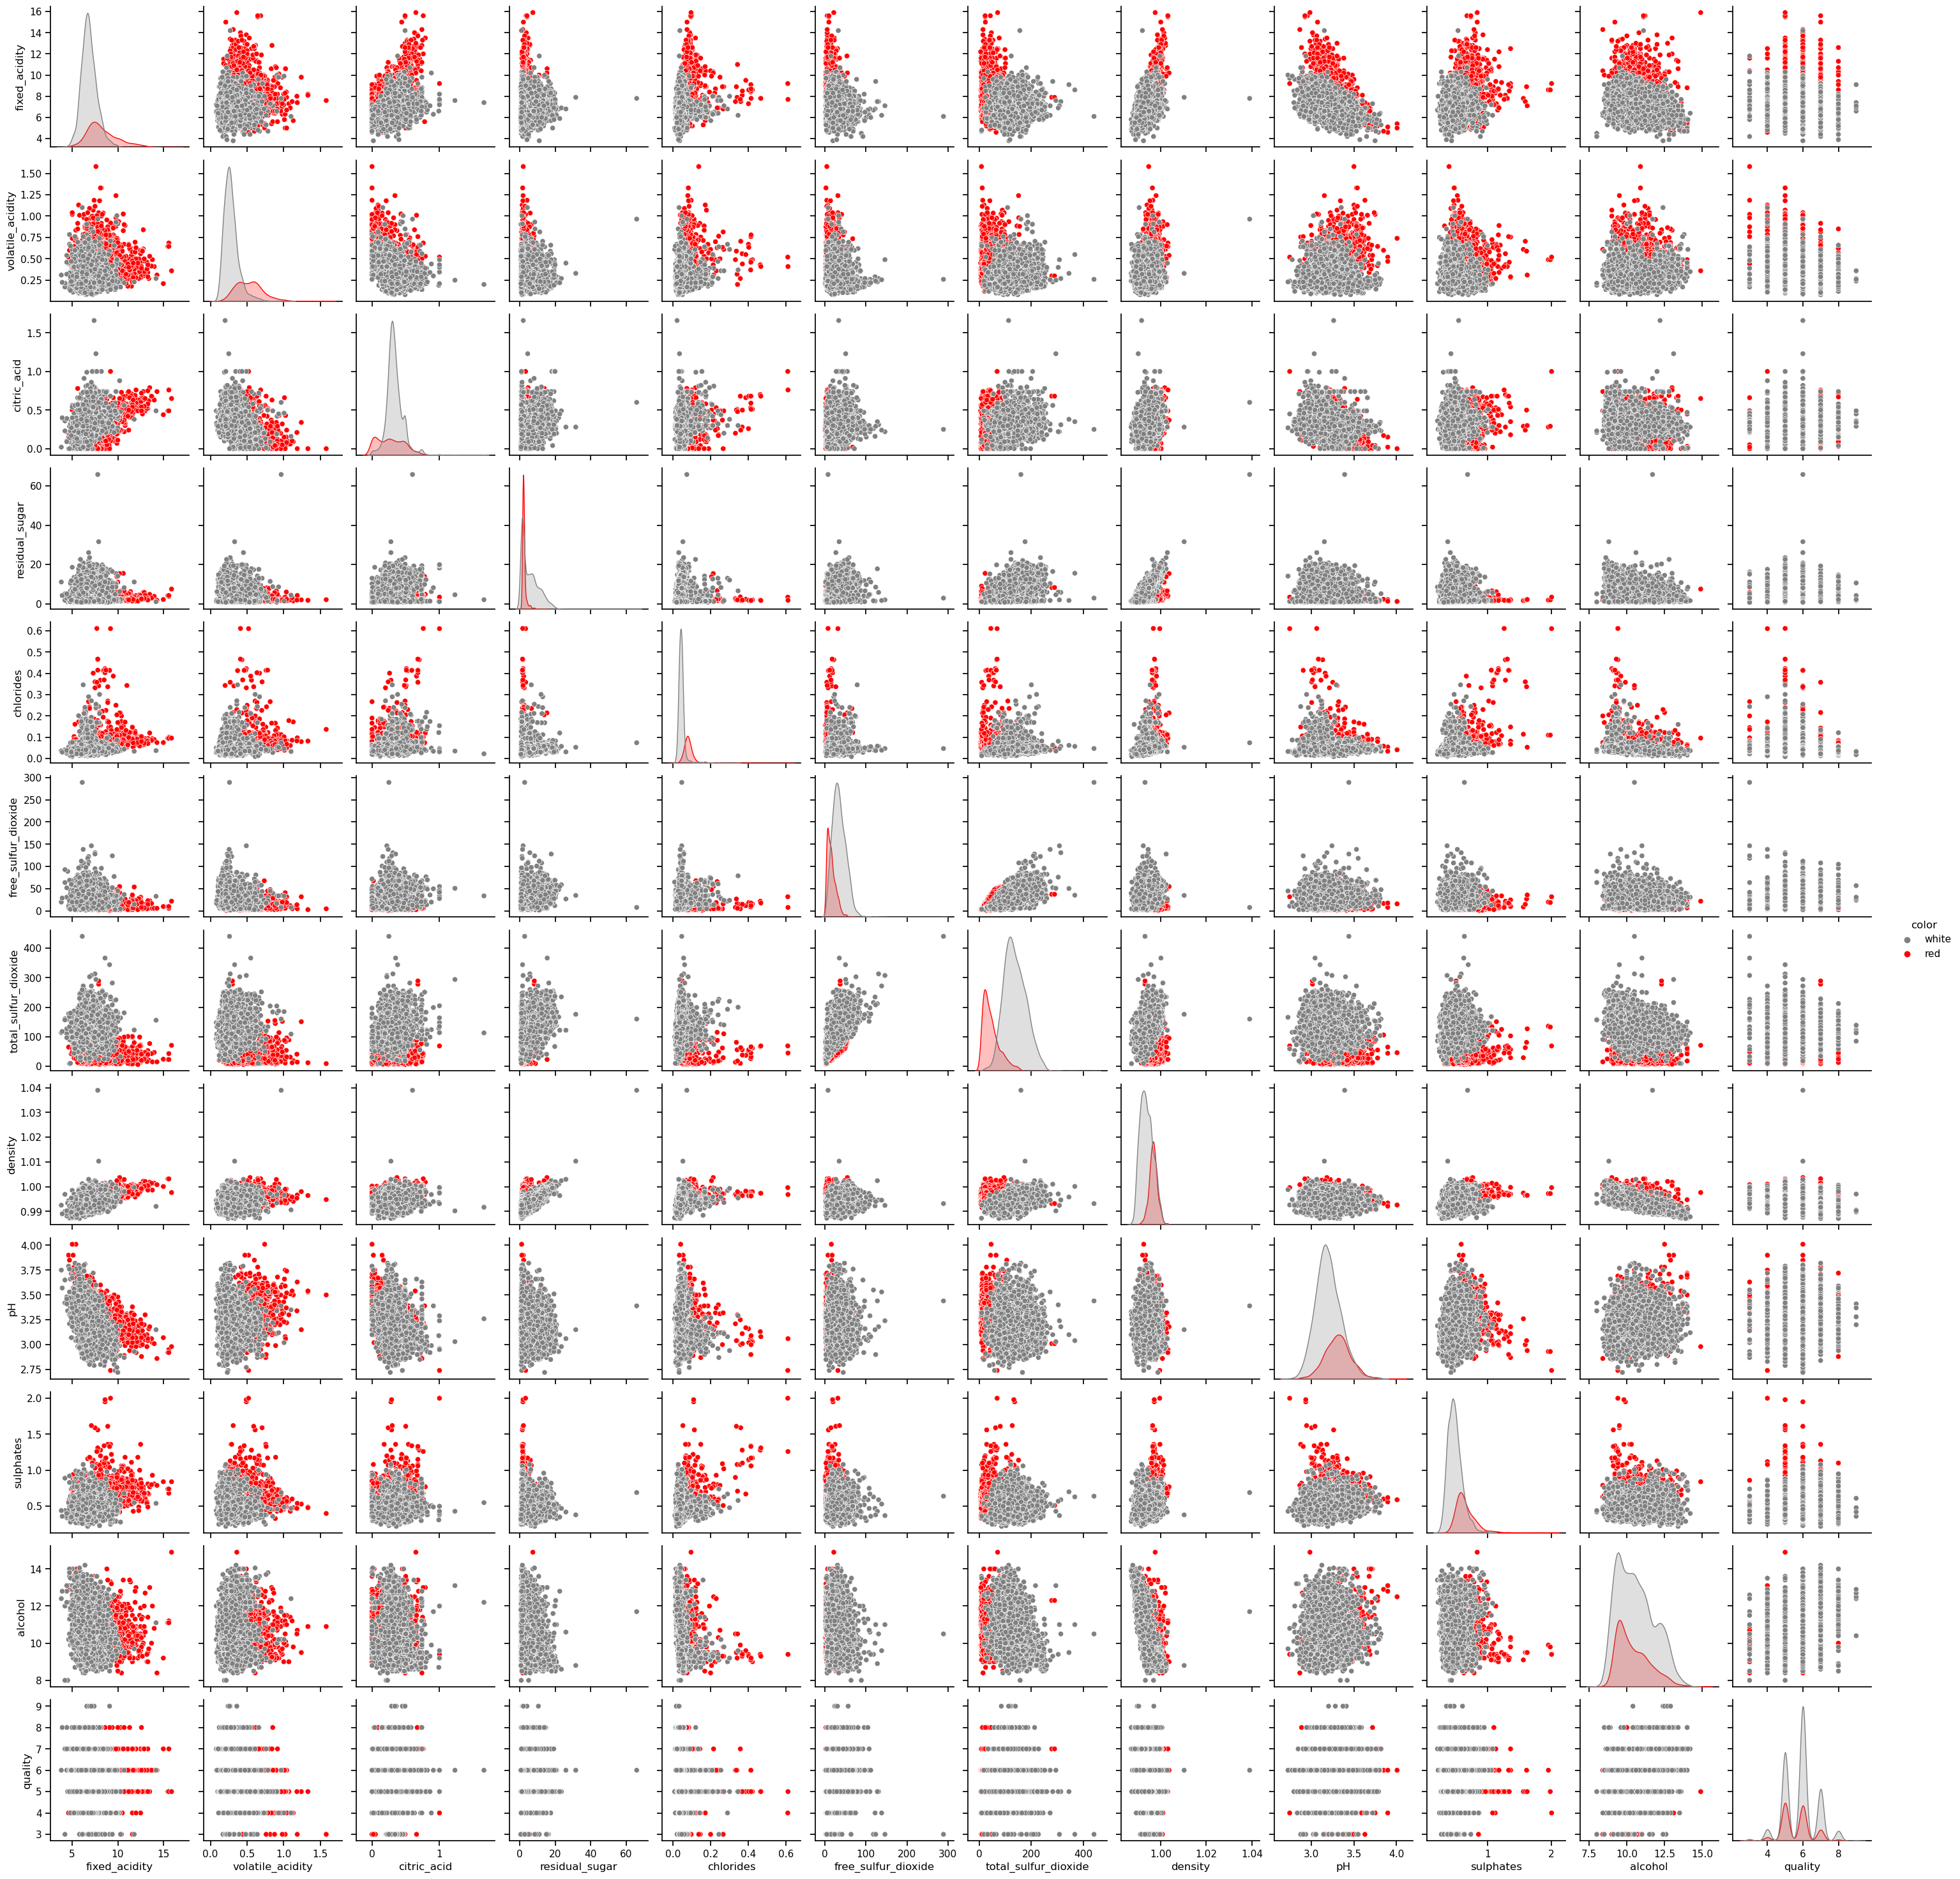

In [30]:
# relaciones entre las variables, con distinción de color
temp = df2[float_columns + ['color']]

sns.set_context('notebook')
sns.pairplot(temp, 
             hue='color', 
             hue_order=['white', 'red'],
             palette={'red':'red', 'white':'gray'});

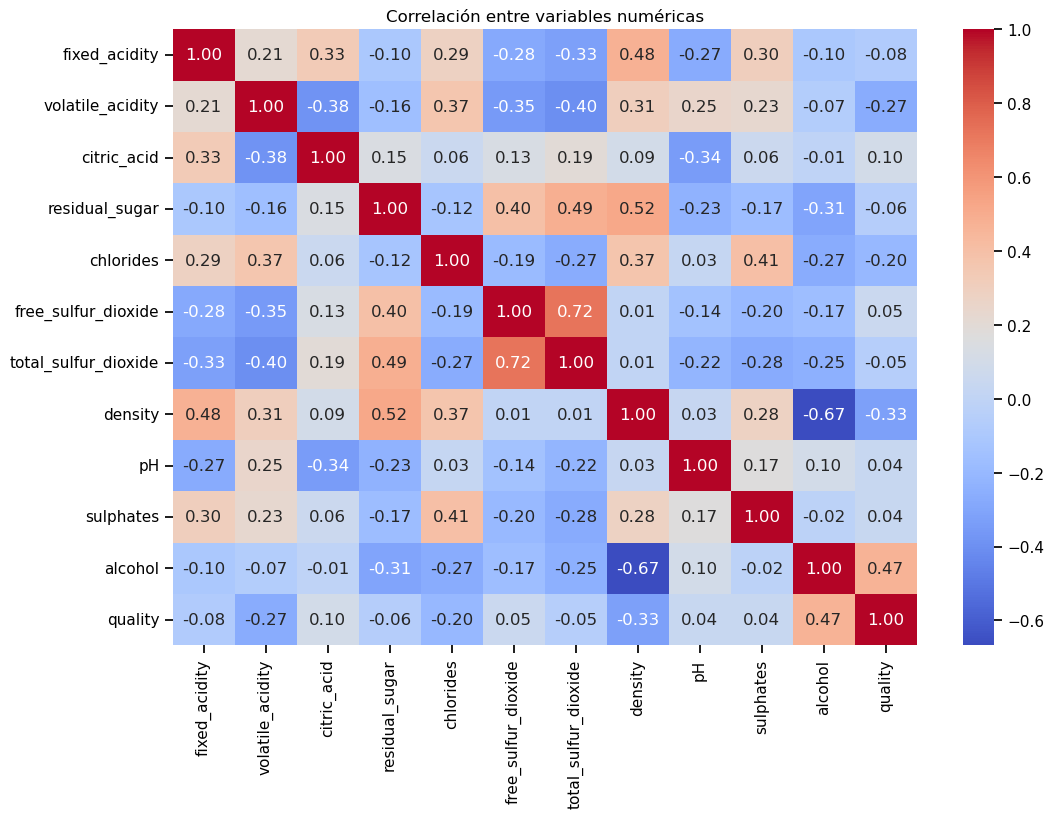

In [14]:
df_numeric = df2.drop(columns=['color'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Generar el gráfico de correlación utilizando seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre variables numéricas')
plt.show()

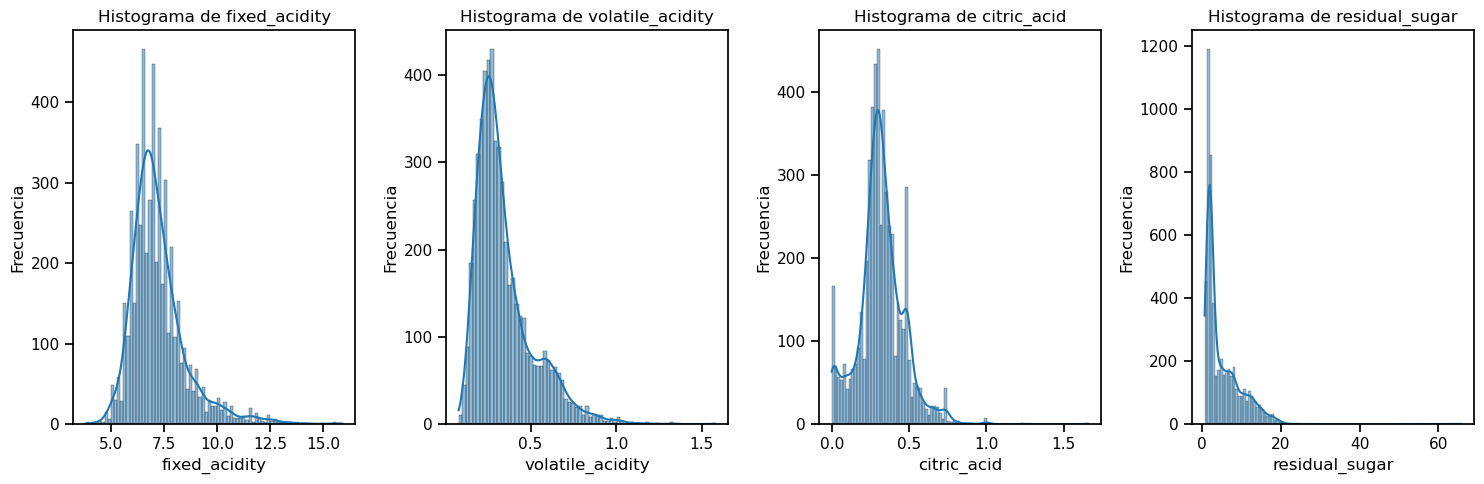

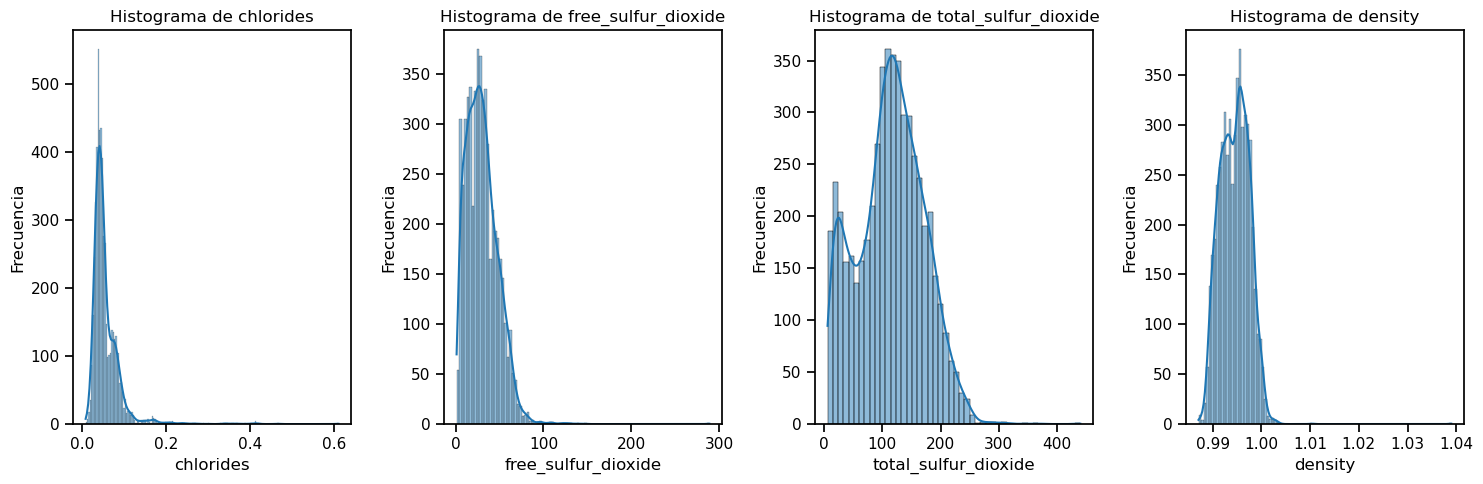

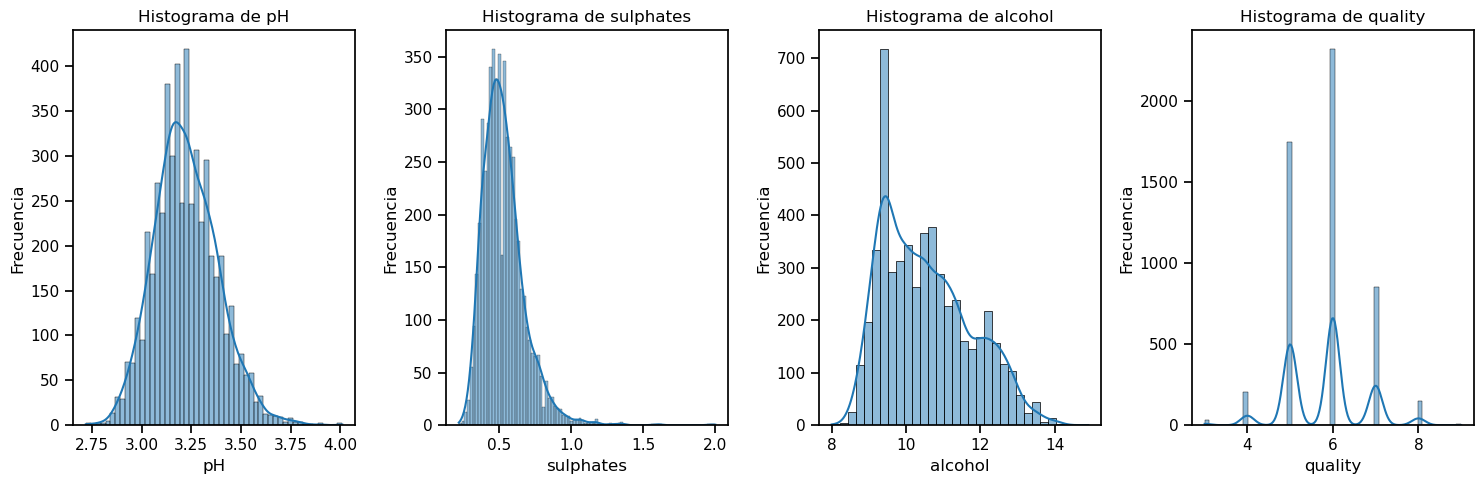

In [17]:
# Configurar el número de columnas en la disposición de subplots
num_columnas = 4

# Histogramas para variables numéricas
for i, num_var in enumerate(float_columns):
    if i % num_columnas == 0:
        plt.figure(figsize=(15, 5))
    plt.subplot(1, num_columnas, i % num_columnas + 1)
    sns.histplot(df2[num_var], kde=True)
    plt.title(f'Histograma de {num_var}')
    plt.xlabel(num_var)
    plt.ylabel('Frecuencia')
    if (i + 1) % num_columnas == 0 or i == len(float_columns) - 1:
        plt.tight_layout()
        plt.show()

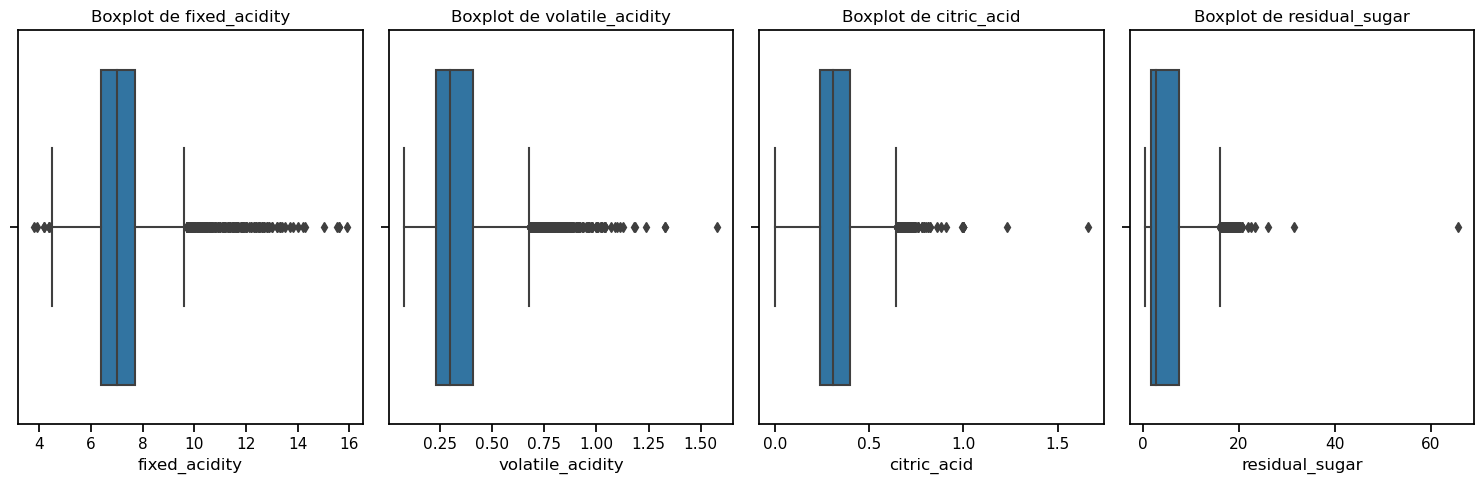

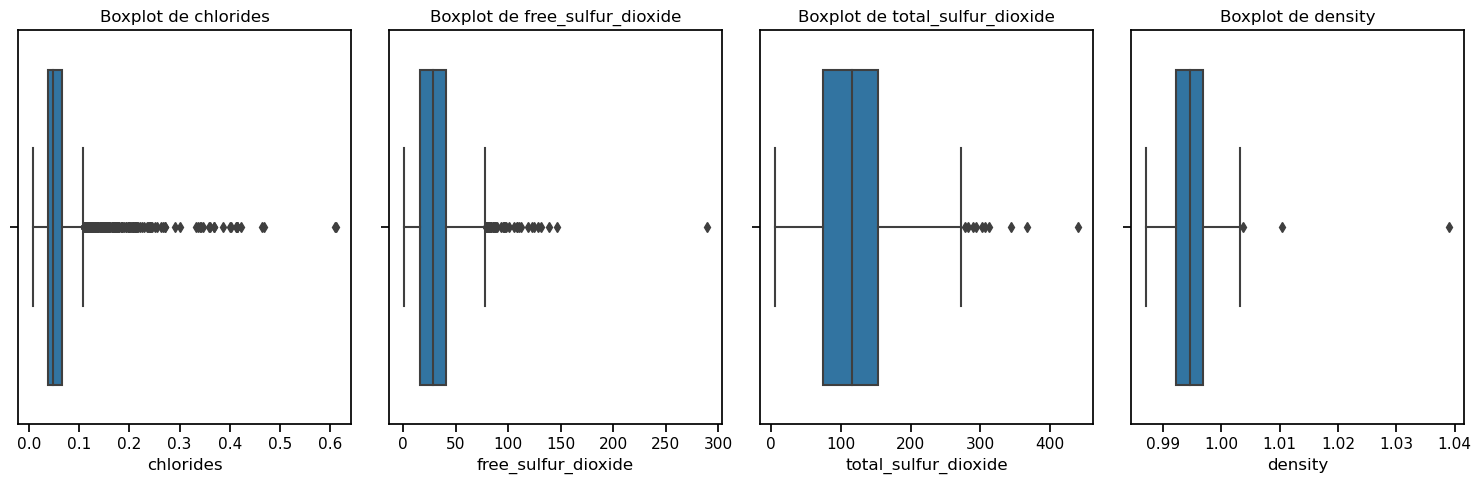

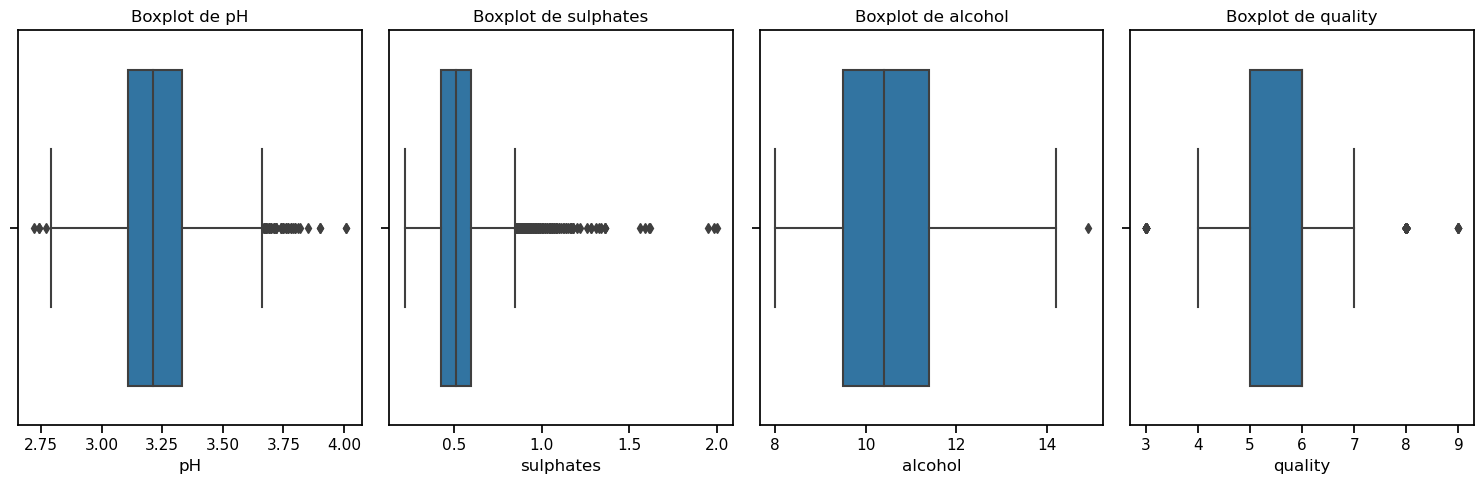

In [18]:
# Boxplots para variables numéricas
for i, num_var in enumerate(float_columns):
    if i % num_columnas == 0:
        plt.figure(figsize=(15, 5))
    plt.subplot(1, num_columnas, i % num_columnas + 1)
    sns.boxplot(x=df2[num_var])
    plt.title(f'Boxplot de {num_var}')
    plt.xlabel(num_var)
    if (i + 1) % num_columnas == 0 or i == len(float_columns) - 1:
        plt.tight_layout()
        plt.show()

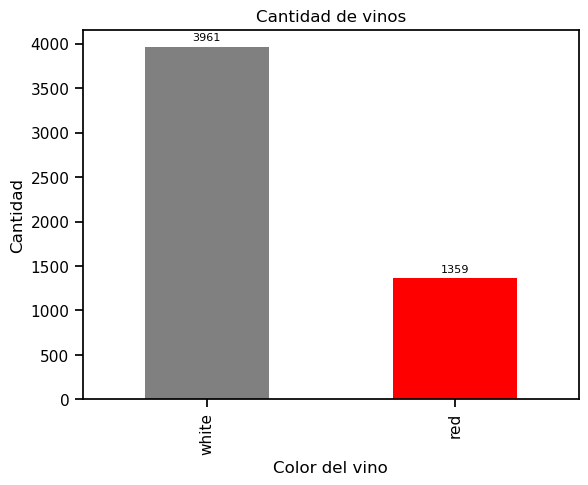

In [37]:
# análisis de color
color_counts = df2['color'].value_counts()
ax = color_counts.plot(kind='bar', color=['gray', 'red'])
for i, v in enumerate(color_counts):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=8)
plt.xlabel('Color del vino')
plt.ylabel('Cantidad')
plt.title('Cantidad de vinos')
plt.show()

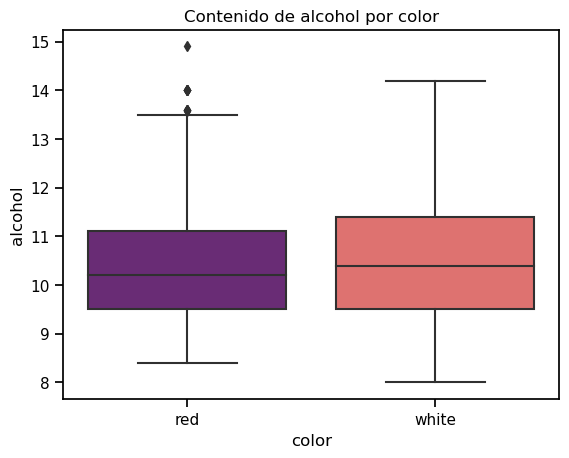

In [51]:
# contenido de alcohol por color
sns.boxplot(x='color', y='alcohol', data=df2, palette = 'magma')
plt.title('Contenido de alcohol por color')
plt.show()

# Preprocesamiento de los datos

## Tratamiento de valores atípicos quantiles

In [52]:
# Crear una copia del DataFrame original
df3 = df2.copy()

# Identificar y manejar outliers en cada columna numérica
for column in df3.columns:
    if df3[column].dtype != 'object': 
        q1 = df3[column].quantile(0.25)
        q3 = df3[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Reemplazar los valores atípicos por los límites del rango intercuartílico
        df3[column] = df3[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

In [53]:
df3.shape

(5320, 13)

In [54]:
# Descripción estadística general de las variables categóricas
df3.describe(include=['object'])

color
count    5320
unique      2
top     white
freq     3961

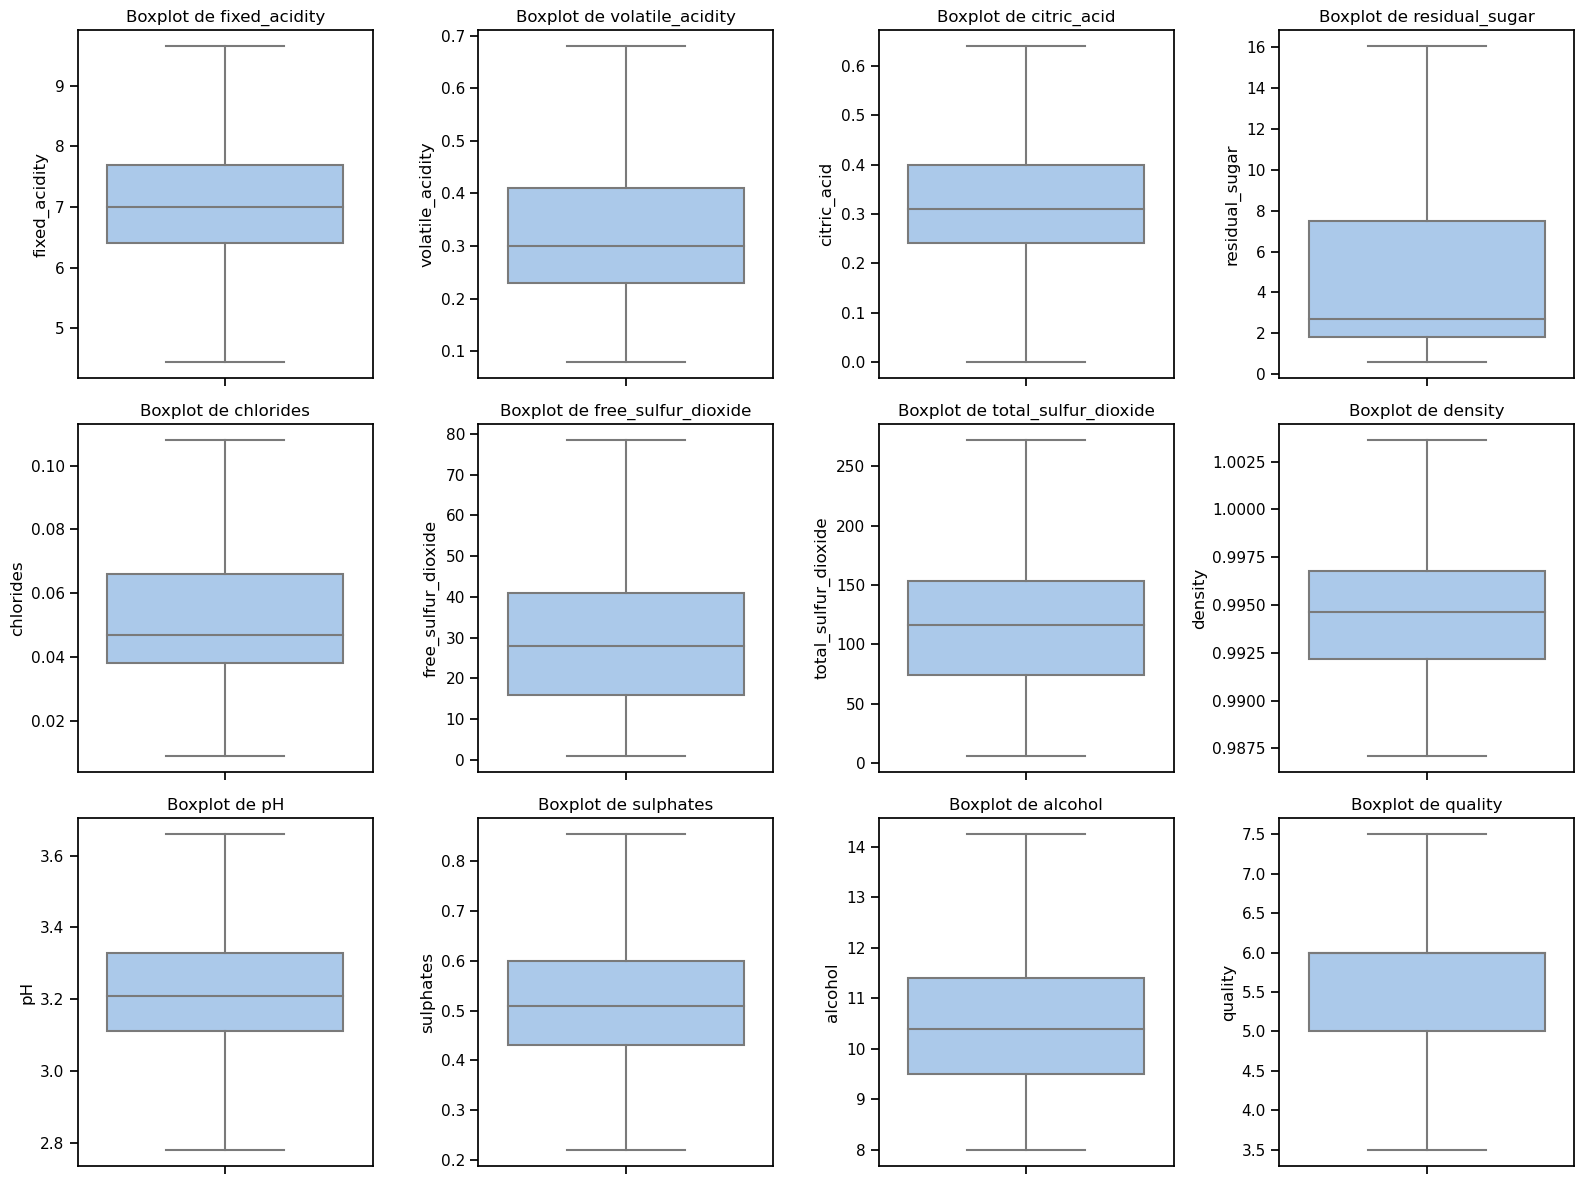

In [63]:
# Boxplots horizontales separados para cada variable en el DataFrame winsorizado
num_variables = df3.drop(columns=['color']).shape[1]
num_cols = min(num_variables, 4)  # Máximo 4 columnas
num_rows = (num_variables + num_cols - 1) // num_cols  # Calcular número de filas

plt.figure(figsize=(num_cols * 4, num_rows * 4))
for i, column in enumerate(df3.drop(columns=['color']).columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(y=df3[column], palette='pastel')
    plt.title(f'Boxplot de {column}')
    plt.tight_layout()

plt.show()

## Tratamiento de atípicos Winsorized

In [56]:
# Crear una copia del DataFrame original
df_winsorized = df2.copy()

# Seleccionar las columnas numéricas
numeric_columns = df_winsorized.select_dtypes(include=np.number).columns

# Aplicar la winsorización a cada columna numérica
for column in numeric_columns:
    # Calcular los percentiles 5 y 95
    p5 = np.percentile(df_winsorized[column], 5)
    p95 = np.percentile(df_winsorized[column], 95)
    # Reemplazar los valores atípicos con los valores correspondientes a los percentiles 5 y 95
    df_winsorized[column] = np.where(df_winsorized[column] < p5, p5, df_winsorized[column])
    df_winsorized[column] = np.where(df_winsorized[column] > p95, p95, df_winsorized[column])

# Mostrar las primeras filas del DataFrame winsorizado
df_winsorized.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.68         0.04             1.9      0.076   
1            7.8              0.68         0.04             2.6      0.098   
2            7.8              0.68         0.04             2.3      0.092   
3            9.8              0.28         0.56             1.9      0.075   
5            7.4              0.66         0.04             1.8      0.075   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.50       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
5                 13.0                  40.0   0.9978  3.50       0.56   

   alcohol  quality color  
0      9.4      5.0   red  
1      9.8      5.0   red  
2      9.8      5.0   red  
3      9.8      6.0   red  
5      9.4      5.0   red

In [57]:
df_winsorized.shape

(5320, 13)

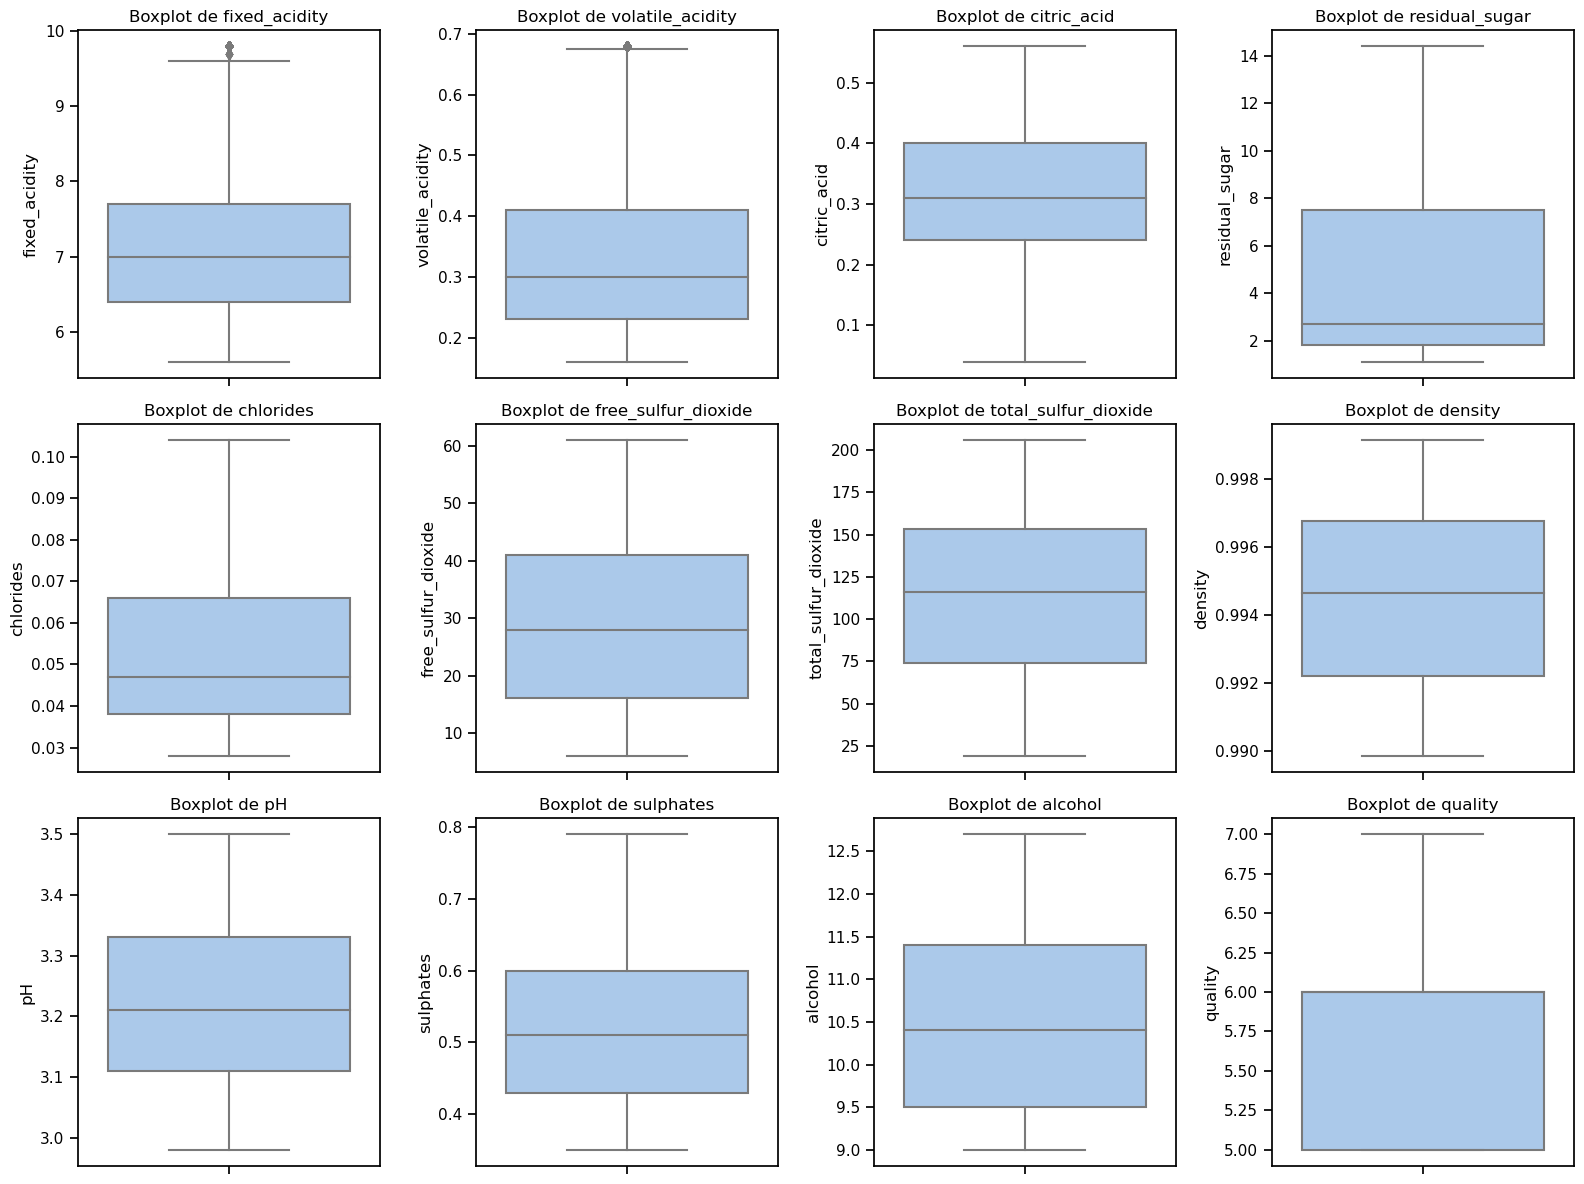

In [58]:
# Boxplots horizontales separados para cada variable en el DataFrame winsorizado
num_variables = df_winsorized.drop(columns=['color']).shape[1]
num_cols = min(num_variables, 4)  # Máximo 4 columnas
num_rows = (num_variables + num_cols - 1) // num_cols  # Calcular número de filas

plt.figure(figsize=(num_cols * 4, num_rows * 4))
for i, column in enumerate(df_winsorized.drop(columns=['color']).columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(y=df_winsorized[column], palette='pastel')
    plt.title(f'Boxplot de {column}')
    plt.tight_layout()

plt.show()

## Reemplazo de las observaciones red and white por las proporciones 

In [62]:
# Calcular la proporción de cada categoría en la columna 'color'
# para el dataframe con tratamiento de atípicos de quantiles 
color_proportions = df3['color'].value_counts(normalize=True)

# Renombrar la variable 'color' por la proporción respectiva en el conjunto de datos
df3['color'] = df3['color'].map(color_proportions)
display(df3.head(2))
display(df3.tail(2))

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.68          0.0             1.9      0.076   
1            7.8              0.68          0.0             2.6      0.098   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   

   alcohol  quality     color  
0      9.4      5.0  0.255451  
1      9.8      5.0  0.255451

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality     color  
6495     12.8      7.0  0.744549  
6496     11.8      6.0  0.744549

In [65]:
# Calcular la proporción de cada categoría en la columna 'color'
# para el dataframe con tratamiento de atípicos de winzorized
color_proportions = df_winsorized['color'].value_counts(normalize=True)

# Renombrar la variable 'color' por la proporción respectiva en el conjunto de datos
df_winsorized['color'] = df_winsorized['color'].map(color_proportions)

# Mostrar las primeras filas del DataFrame con la variable 'color' renombrada
display(df_winsorized.head(2))
display(df_winsorized.tail(2))

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.68         0.04             1.9      0.076   
1            7.8              0.68         0.04             2.6      0.098   

   free_sulfur_dioxide  total_sulfur_dioxide  density   pH  sulphates  \
0                 11.0                  34.0   0.9978  3.5       0.56   
1                 25.0                  67.0   0.9968  3.2       0.68   

   alcohol  quality     color  
0      9.4      5.0  0.255451  
1      9.8      5.0  0.255451

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
6495            5.6              0.29         0.30             1.1      0.028   
6496            6.0              0.21         0.38             1.1      0.028   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
6495                 20.0                 110.0  0.98985  3.34       0.38   
6496                 22.0                  98.0  0.98985  3.26       0.35   

      alcohol  quality     color  
6495     12.7      7.0  0.744549  
6496     11.8      6.0  0.744549

## Escalado

In [73]:
# Scaling data 
scaler = StandardScaler()
scaler.fit(df3)
scaled1q = pd.DataFrame(scaler.transform(df3),columns = df3.columns)

# Scaled data
scaled1q.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.238055          2.298926    -2.273272       -0.724004   1.019157   
1       0.605077          2.298926    -2.273272       -0.559650   2.020762   
2       0.605077          2.298926    -1.985367       -0.630087   1.747597   
3       2.302554         -0.386644     1.757397       -0.724004   0.973630   
4       0.238055          2.164647    -2.273272       -0.747483   0.973630   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.114479             -1.417952  1.128801  1.812423   0.240980   
1            -0.287116             -0.833163  0.783878 -0.151665   1.156786   
2            -0.878090             -1.063534  0.852863  0.228481   0.927835   
3            -0.759895             -0.957209  1.197786 -0.405096   0.393614   
4            -0.996285             -1.311627  1.128801  1.812423   0.240980   

    alcohol   quality     color  
0 -0.969388 -0.937379 -1.707233  
1 -0.631951 -0.937379 -1.707233  
2 -0.631951 -0.937379 -1.707233  
3 -0.631951  0.259515 -1.707233  
4 -0.969388 -0.937379 -1.707233

In [74]:
scaled1q.describe()

fixed_acidity  volatile_acidity   citric_acid  residual_sugar  \
count   5.320000e+03      5.320000e+03  5.320000e+03    5.320000e+03   
mean   -8.547883e-17      8.547883e-17 -8.547883e-17   -2.136971e-16   
std     1.000094e+00      1.000094e+00  1.000094e+00    1.000094e+00   
min    -2.468731e+00     -1.729429e+00 -2.273272e+00   -1.029232e+00   
25%    -6.794994e-01     -7.223400e-01 -5.458422e-01   -7.474828e-01   
50%    -1.289665e-01     -2.523653e-01 -4.200868e-02   -5.361709e-01   
75%     5.133219e-01      4.861664e-01  6.057773e-01    5.908260e-01   
max     2.302554e+00      2.298926e+00  2.333207e+00    2.598289e+00   

          chlorides  free_sulfur_dioxide  total_sulfur_dioxide       density  \
count  5.320000e+03          5320.000000          5.320000e+03  5.320000e+03   
mean   3.419153e-16             0.000000          2.136971e-17  2.842171e-15   
std    1.000094e+00             1.000094          1.000094e+00  1.000094e+00   
min   -2.031186e+00            -1.705453         -1.914137e+00 -2.558431e+00   
25%   -7.108880e-01            -0.818992         -7.091163e-01 -8.027702e-01   
50%   -3.011405e-01            -0.109824          3.516115e-02  4.229235e-02   
75%    5.638821e-01             0.658441          6.952644e-01  7.735301e-01   
max    2.476037e+00             2.874591          2.801836e+00  3.137981e+00   

                 pH     sulphates       alcohol       quality         color  
count  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03  
mean   1.132594e-15 -2.778062e-16 -1.431770e-15 -4.434214e-16 -2.136971e-16  
std    1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00  
min   -2.812689e+00 -2.353804e+00 -2.150417e+00 -2.732720e+00 -1.707233e+00  
25%   -7.218847e-01 -7.511432e-01 -8.850289e-01 -9.373794e-01 -1.707233e+00  
50%   -8.830777e-02 -1.406058e-01 -1.257957e-01  2.595145e-01  5.857433e-01  
75%    6.719846e-01  5.462488e-01  7.177967e-01  2.595145e-01  5.857433e-01  
max    2.762789e+00  2.492337e+00  3.122035e+00  2.054855e+00  5.857433e-01

In [75]:
# Scaling data 
scaler = StandardScaler()
scaler.fit(df_winsorized)
scaled2w = pd.DataFrame(scaler.transform(df_winsorized),columns = df_winsorized.columns)

# Scaled data
scaled2w.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.217595          2.313302    -2.115235       -0.737525   1.053881   
1       0.587157          2.313302    -2.115235       -0.566956   2.090892   
2       0.587157          2.313302    -2.115235       -0.640057   1.808071   
3       2.434967         -0.397313     1.894733       -0.737525   1.006744   
4       0.217595          2.177771    -2.115235       -0.761892   1.006744   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.161863             -1.468618  1.197672  1.921114   0.265640   
1            -0.285287             -0.857554  0.833633 -0.159077   1.245858   
2            -0.911413             -1.098276  0.906441  0.256961   1.000804   
3            -0.786188             -0.987174  1.270479 -0.436436   0.429010   
4            -1.036638             -1.357516  1.197672  1.921114   0.265640   

    alcohol   quality     color  
0 -1.009853 -1.121380 -1.707233  
1 -0.654805 -1.121380 -1.707233  
2 -0.654805 -1.121380 -1.707233  
3 -0.654805  0.252898 -1.707233  
4 -1.009853 -1.121380 -1.707233

In [76]:
scaled2w.describe()

fixed_acidity  volatile_acidity   citric_acid  residual_sugar  \
count   5.320000e+03      5.320000e+03  5.320000e+03    5.320000e+03   
mean   -3.846547e-16      2.564365e-16 -6.410912e-17   -6.410912e-17   
std     1.000094e+00      1.000094e+00  1.000094e+00    1.000094e+00   
min    -1.445433e+00     -1.210497e+00 -2.115235e+00   -9.324612e-01   
25%    -7.063096e-01     -7.361394e-01 -5.729395e-01   -7.618922e-01   
50%    -1.519667e-01     -2.617819e-01 -3.313616e-02   -5.425893e-01   
75%     4.947667e-01      4.836370e-01  6.608968e-01    6.270264e-01   
max     2.434967e+00      2.313302e+00  1.894733e+00    2.308349e+00   

          chlorides  free_sulfur_dioxide  total_sulfur_dioxide       density  \
count  5.320000e+03         5.320000e+03          5.320000e+03  5.320000e+03   
mean   8.547883e-17        -2.136971e-17         -4.273941e-17  4.224791e-14   
std    1.000094e+00         1.000094e+00          1.000094e+00  1.000094e+00   
min   -1.208688e+00        -1.474926e+00         -1.746375e+00 -1.696614e+00   
25%   -7.373198e-01        -8.488005e-01         -7.279344e-01 -8.409420e-01   
50%   -3.130880e-01        -9.744965e-02          4.978385e-02  5.095145e-02   
75%    5.825124e-01         7.165138e-01          7.395459e-01  8.227123e-01   
max    2.373713e+00         1.968765e+00          1.716323e+00  1.693127e+00   

                 pH     sulphates       alcohol       quality         color  
count  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03  
mean   1.709577e-15  2.350668e-16  1.282182e-15 -3.205456e-17 -2.136971e-16  
std    1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00  
min   -1.684551e+00 -1.449742e+00 -1.364900e+00 -1.121380e+00 -1.707233e+00  
25%   -7.831345e-01 -7.962631e-01 -9.210910e-01 -1.121380e+00 -1.707233e+00  
50%   -8.973756e-02 -1.427842e-01 -1.222344e-01  2.528981e-01  5.857433e-01  
75%    7.423388e-01  5.923795e-01  7.653841e-01  2.528981e-01  5.857433e-01  
max    1.921114e+00  2.148476e+00  1.919288e+00  1.627176e+00  5.857433e-01

# Reducción de la dimensionalidad

In [81]:
#Cree un dataset reducido que proporcione el 85% de la varianza de entrada que debe explicarse
pcaq = PCA(n_components=0.85).fit(scaled1q)

#Veamos cuántas componentes ha conservado PCA:
pcaq.n_components_

7

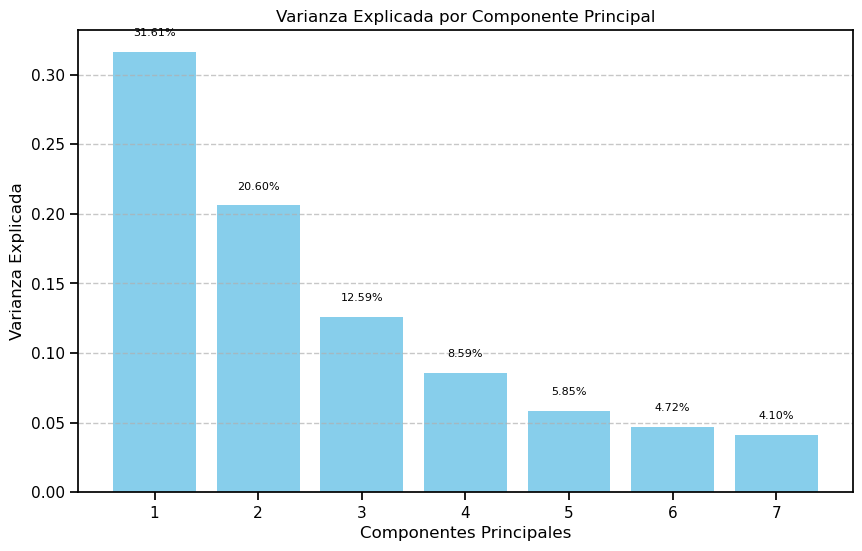

In [93]:
# Obtén la varianza explicada por cada componente
variance_explained = pcaq.explained_variance_ratio_

# Calcula el número de componentes
n_components = pcaq.n_components_

# Crea un array con los índices de los componentes (para el eje x del gráfico)
component_indices = np.arange(1, n_components + 1)

# Crea el gráfico de barras para la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
bars = plt.bar(component_indices, variance_explained, color='skyblue')
plt.bar(component_indices, variance_explained, color='skyblue')
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')

# Agregar etiquetas con el porcentaje de varianza sobre cada barra
for bar, var_explained in zip(bars, variance_explained):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{var_explained*100:.2f}%', ha='center', va='bottom',fontsize=8, color='black')

plt.xticks(component_indices)  # Mostrar todos los componentes en el eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Añadir líneas de cuadrícula en el eje y
plt.show()

In [94]:
#Por último, transforme "scaled1q" de 13 columnas X_pca
X_pca = pcaq.fit_transform(scaled1q)
X_pca

array([[ 4.1019344 , -0.12930929, -2.60852212, ...,  0.40889745,
        -0.24080909, -0.18240693],
       [ 3.91778991,  0.59967298, -1.55597747, ...,  0.58404525,
         1.69395007,  0.2665063 ],
       [ 4.07617966,  0.32336977, -1.48349279, ...,  0.5297617 ,
         0.99353145,  0.25110629],
       ...,
       [-1.08115051, -0.40337348, -0.15597283, ..., -0.17684677,
         0.48224902, -0.1397717 ],
       [-1.87722336, -3.59119184, -0.28820191, ...,  0.32882797,
        -0.39664545, -0.38356983],
       [-1.94836188, -2.52290308,  0.08245025, ..., -0.41278947,
        -0.75999132, -0.44264173]])

##### para el dataset winzerizado 

In [82]:
#Cree un dataset reducido que proporcione el 85% de la varianza de entrada que debe explicarse
pcaw = PCA(n_components=0.85).fit(scaled2w)

#Veamos cuántas componentes ha conservado PCA:
pcaw.n_components_

7

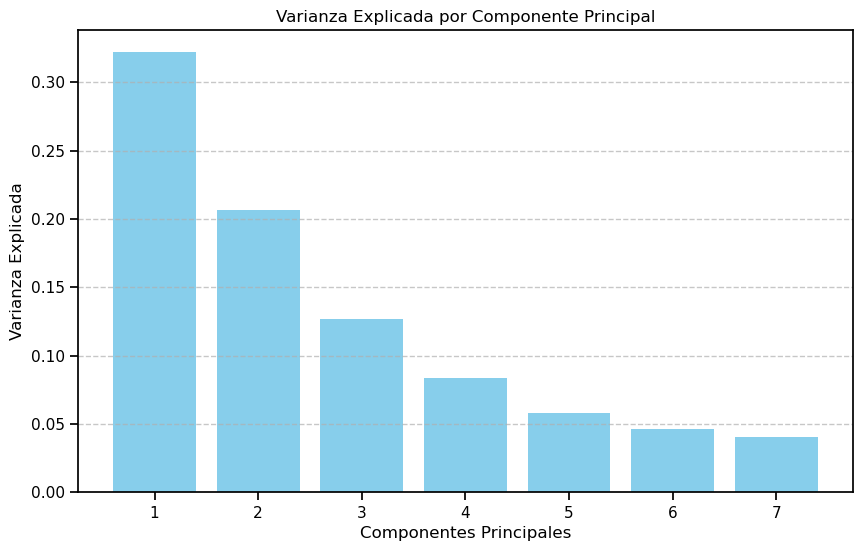

In [87]:
# Obtén la varianza explicada por cada componente
variance_explained = pcaw.explained_variance_ratio_

# Calcula el número de componentes
n_componentsw = pcaw.n_components_

# Crea un array con los índices de los componentes (para el eje x del gráfico)
component_indices = np.arange(1, n_componentsw + 1)

# Crea el gráfico de barras para la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(component_indices, variance_explained, color='skyblue')
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')
plt.xticks(component_indices)  # Mostrar todos los componentes en el eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Añadir líneas de cuadrícula en el eje y
plt.show()

## Clustering Algorithm: K-Means

### Dataset  Original Escalado

In [96]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(scaled1q)
    inertia_list.append(kmeans.inertia_)

  File "c:\Users\osiri\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


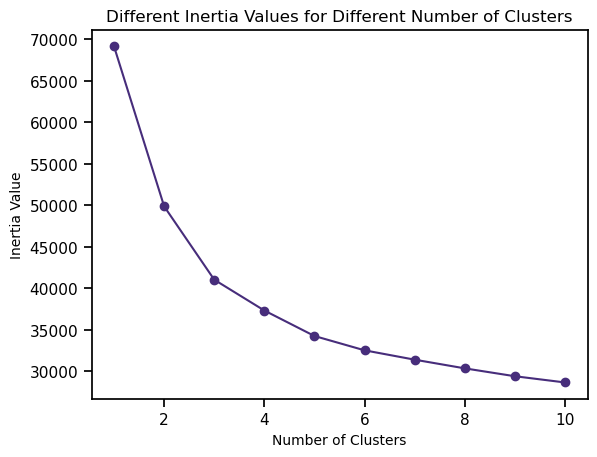

In [97]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [98]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

3

In [99]:
kmeans_constants = {"init": "k-means++", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans.fit(scaled1q)

KMeans(max_iter=500, n_clusters=3, n_init=100, random_state=42)

In [100]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(scaled1q, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(scaled1q, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  41050.011536102305
Silhouette Score:  0.24075039586649977
Calinski harabasz score:  1820.47218830983


In [101]:
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(scaled1q)
Cluster_1

array([1, 1, 1, ..., 0, 0, 0])

In [102]:
# crear un dataset para adjuntar los resultados de todos los cluster realizados.
# Vamos a adjuntar 'Cluster_1' como una nueva variable a 'scaled1q':
df_final = scaled1q.copy()
df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.238055          2.298926    -2.273272       -0.724004   1.019157   
1       0.605077          2.298926    -2.273272       -0.559650   2.020762   
2       0.605077          2.298926    -1.985367       -0.630087   1.747597   
3       2.302554         -0.386644     1.757397       -0.724004   0.973630   
4       0.238055          2.164647    -2.273272       -0.747483   0.973630   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.114479             -1.417952  1.128801  1.812423   0.240980   
1            -0.287116             -0.833163  0.783878 -0.151665   1.156786   
2            -0.878090             -1.063534  0.852863  0.228481   0.927835   
3            -0.759895             -0.957209  1.197786 -0.405096   0.393614   
4            -0.996285             -1.311627  1.128801  1.812423   0.240980   

    alcohol   quality     color  Cluster_1  
0 -0.969388 -0.937379 -1.707233          1  
1 -0.631951 -0.937379 -1.707233          1  
2 -0.631951 -0.937379 -1.707233          1  
3 -0.631951  0.259515 -1.707233          1  
4 -0.969388 -0.937379 -1.707233          1

In [103]:
df_final.Cluster_1.value_counts()

Cluster_1
0    2435
2    1536
1    1349
Name: count, dtype: int64

### Dataset reducido

In [104]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(X_pca)
    inertia_list.append(kmeans.inertia_)

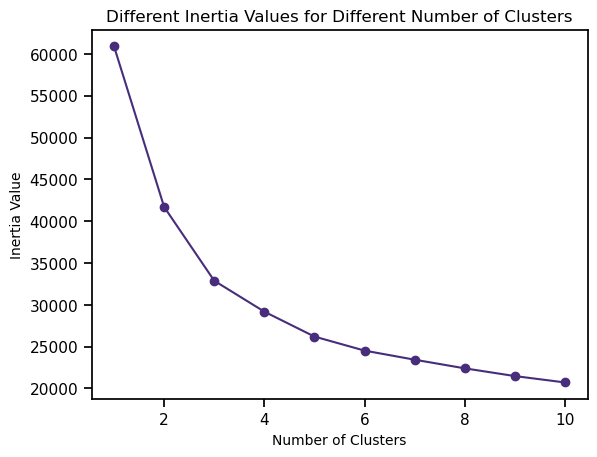

In [105]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [106]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

3

In [107]:
kmeans_constants = {"init": "k-means++", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans_pca = KMeans(n_clusters = 3, **kmeans_constants)
model_kmeans_pca.fit(X_pca)

KMeans(max_iter=500, n_clusters=3, n_init=100, random_state=42)

In [108]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans_pca.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca, model_kmeans_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, model_kmeans_pca.labels_))

 ### K-MEANS ###
Inertia:  32883.267503246956
Silhouette Score:  0.2760501898607896
Calinski harabasz score:  2265.3837326169305


In [110]:
# Predicción de los clusters
Cluster_2 = model_kmeans.fit_predict(X_pca)

df_final['Cluster_2']= Cluster_2
df_final.head(3)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.238055          2.298926    -2.273272       -0.724004   1.019157   
1       0.605077          2.298926    -2.273272       -0.559650   2.020762   
2       0.605077          2.298926    -1.985367       -0.630087   1.747597   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.114479             -1.417952  1.128801  1.812423   0.240980   
1            -0.287116             -0.833163  0.783878 -0.151665   1.156786   
2            -0.878090             -1.063534  0.852863  0.228481   0.927835   

    alcohol   quality     color  Cluster_1  Cluster_2  
0 -0.969388 -0.937379 -1.707233          1          2  
1 -0.631951 -0.937379 -1.707233          1          2  
2 -0.631951 -0.937379 -1.707233          1          2

In [111]:
df_final['Cluster_2'].value_counts()

Cluster_2
1    2391
0    1581
2    1348
Name: count, dtype: int64

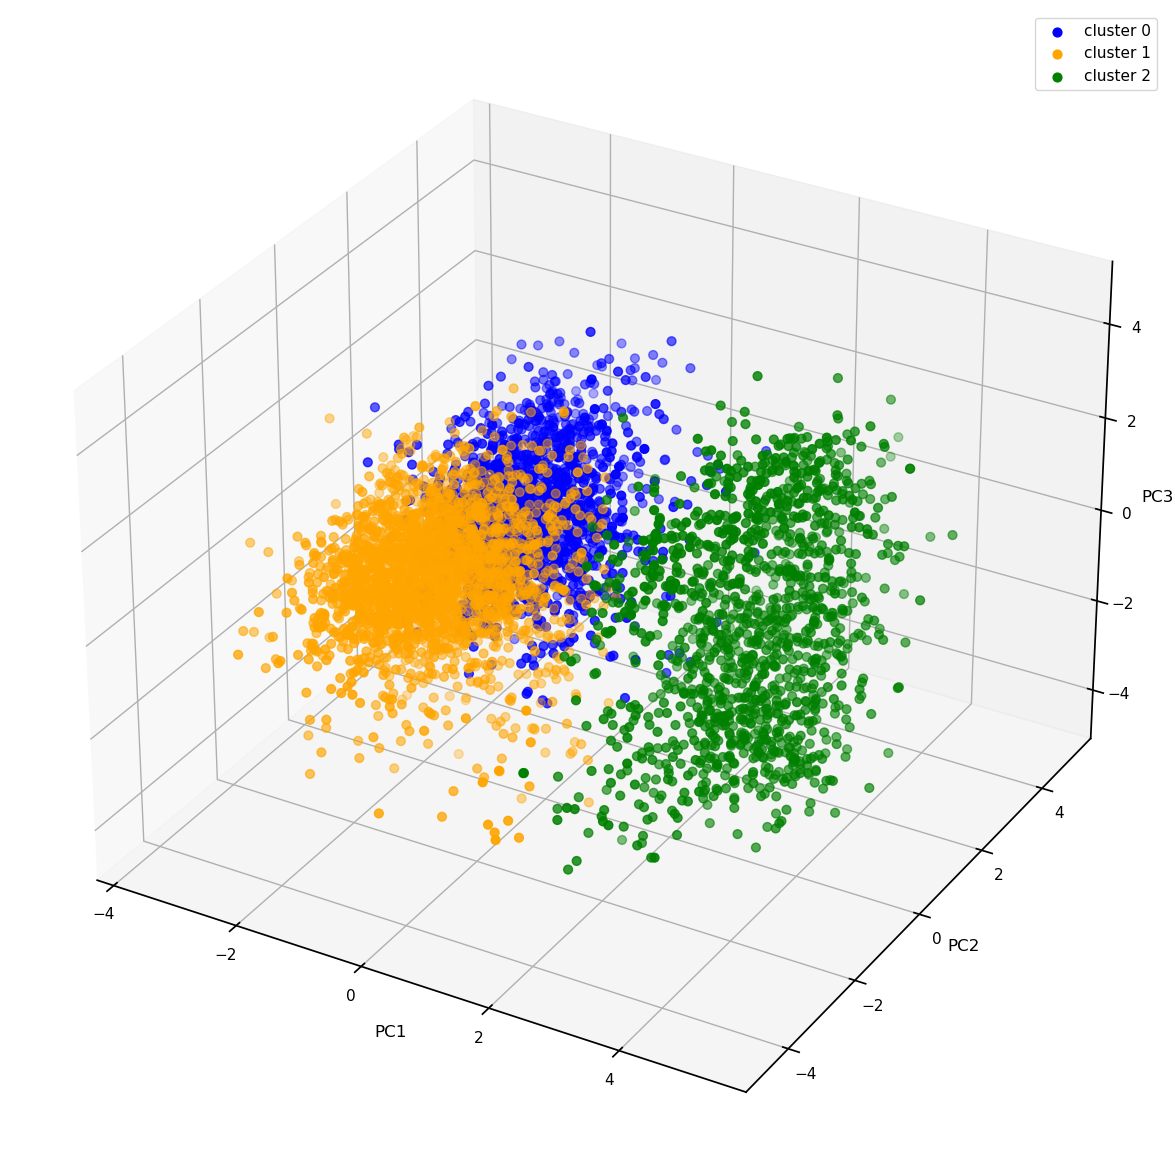

In [115]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_2 == 0,0],X_pca[Cluster_2 == 0,1],X_pca[Cluster_2 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X_pca[Cluster_2 == 1,0],X_pca[Cluster_2 == 1,1],X_pca[Cluster_2 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X_pca[Cluster_2 == 2,0],X_pca[Cluster_2 == 2,1],X_pca[Cluster_2 == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

In [117]:
%pip install plotly
import plotly.express as px

df_temp = pd.DataFrame({'x': X_pca[:, 0], 'y': X_pca[:, 1], 'z': X_pca[:, 2],'label': Cluster_2})
df_temp['label'] = df_temp['label'].astype(str)

fig = px.scatter_3d(df_temp, x="x", y="y", z="z", color="label")
fig.update_layout(width=1000, height=700)
fig.show(config={'displayModeBar': False})

Note: you may need to restart the kernel to use updated packages.


## Clustering Algorithm: Hierarchical Clustering

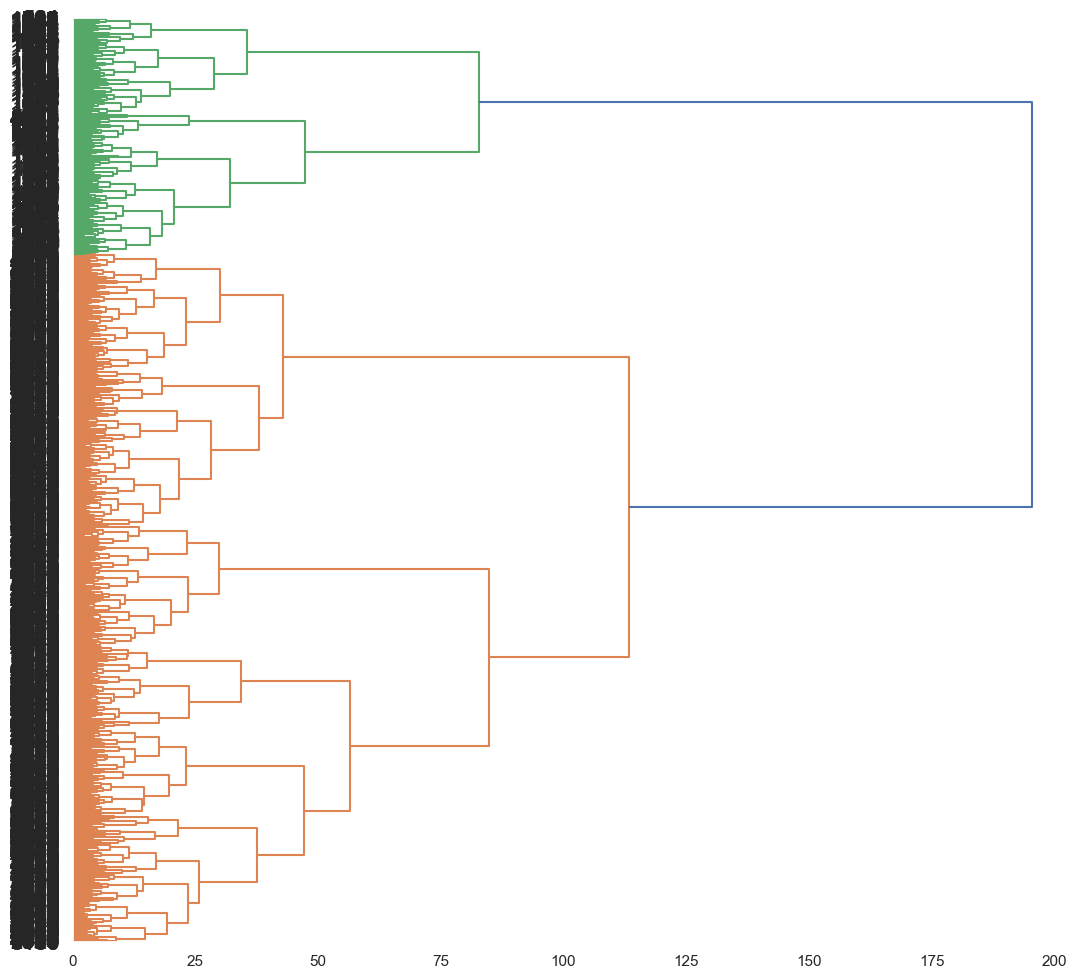

In [118]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Estilo de las gráficas
sns.set_theme()

# Función de vinculación para agrupar datos según similud
Z = linkage(scaled1q, method='ward')

plt.figure(figsize=(13, 12))
dendrogram(
    Z,
    orientation='right',
    distance_sort='descending',
    show_leaf_counts=False,
    leaf_font_size=16
)
plt.show()

In [119]:
from sklearn.cluster import AgglomerativeClustering

model_hc = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
model_hc.fit(scaled1q)

# --- Evaluación del modelo kmeans ---
print(" ### HIERARCHICAL CLUSTERING ###")
print('Silhouette Score: ', silhouette_score(scaled1q, model_hc.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(scaled1q, model_hc.labels_))

 ### HIERARCHICAL CLUSTERING ###
Silhouette Score:  0.3116573766202087
Calinski harabasz score:  2030.607050509823


In [120]:
# Predicción de los clusters
Cluster_3 = model_hc.fit_predict(scaled1q)

df_final['Cluster_3']= Cluster_3

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.238055          2.298926    -2.273272       -0.724004   1.019157   
1       0.605077          2.298926    -2.273272       -0.559650   2.020762   
2       0.605077          2.298926    -1.985367       -0.630087   1.747597   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.114479             -1.417952  1.128801  1.812423   0.240980   
1            -0.287116             -0.833163  0.783878 -0.151665   1.156786   
2            -0.878090             -1.063534  0.852863  0.228481   0.927835   

    alcohol   quality     color  Cluster_1  Cluster_2  Cluster_3  
0 -0.969388 -0.937379 -1.707233          1          2          1  
1 -0.631951 -0.937379 -1.707233          1          2          1  
2 -0.631951 -0.937379 -1.707233          1          2          1

## Clustering Algorithm: DBSCAN

### Dataset original

In [121]:
from sklearn.neighbors import NearestNeighbors

# --- Selección de hiperparámetros eps ---

# --- Gráfica de distancias K --
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(scaled1q)

distances, *other = neighbors.kneighbors(scaled1q)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)

(5320,)


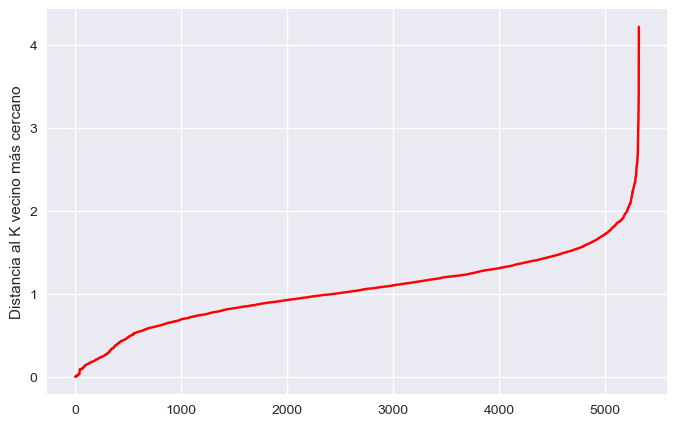

In [122]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [123]:
# --- Selección del punto de curvatura máxima ---
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

5238

In [124]:
# --- Epsilon óptimo --
epsilon = distances[kl.elbow]
epsilon

2.0829113640179324

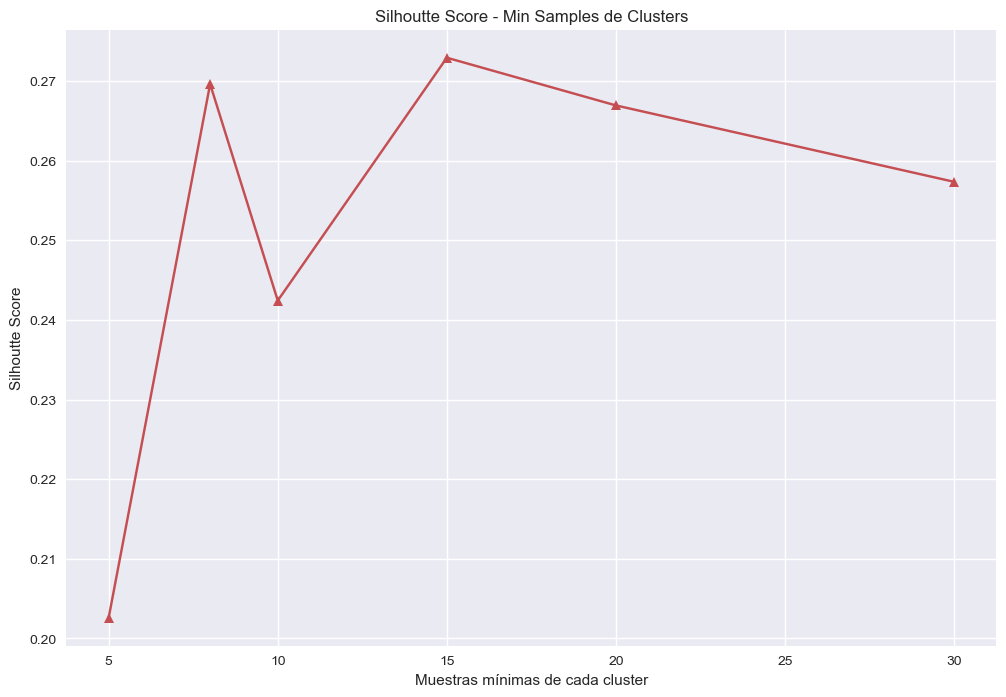

In [125]:
# --- Selección de hiperparámetros min_sample ---
silhoutte_coefs = []

for min_points in [5, 8, 10, 15, 20, 30]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(scaled1q)
    silhoutte_coefs.append(silhouette_score(scaled1q, model_d.labels_))

plt.figure(figsize = (12, 8))
plt.plot([5, 8, 10, 15, 20, 30], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

In [126]:
# --- Modelo DBSCAN ---
model_db = DBSCAN(eps = epsilon, min_samples = 15, n_jobs=-1)
model_db.fit(scaled1q)

DBSCAN(eps=2.0829113640179324, min_samples=15, n_jobs=-1)

In [127]:
# --- Evaluación del modelo DBSCAN ---
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(scaled1q, model_db.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(scaled1q, model_db.labels_))

 ### DBSCAN ###
Silhouette Score:  0.27292156766808523
Calinski harabasz score:  1022.2320779732629


In [128]:
# Predicción de los clusters
Cluster_4 = model_db.fit_predict(scaled1q)

df_final['Cluster_4']= Cluster_4
df_final.head(3)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.238055          2.298926    -2.273272       -0.724004   1.019157   
1       0.605077          2.298926    -2.273272       -0.559650   2.020762   
2       0.605077          2.298926    -1.985367       -0.630087   1.747597   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.114479             -1.417952  1.128801  1.812423   0.240980   
1            -0.287116             -0.833163  0.783878 -0.151665   1.156786   
2            -0.878090             -1.063534  0.852863  0.228481   0.927835   

    alcohol   quality     color  Cluster_1  Cluster_2  Cluster_3  Cluster_4  
0 -0.969388 -0.937379 -1.707233          1          2          1          0  
1 -0.631951 -0.937379 -1.707233          1          2          1          0  
2 -0.631951 -0.937379 -1.707233          1          2          1          0

In [129]:
df_final['Cluster_4'].value_counts()

Cluster_4
 1    3786
 0    1286
-1     248
Name: count, dtype: int64

### Dataset reducido

In [130]:
# --- Selección de hiperparámetros eps ---

# --- Gráfica de distancias K --
neighbors = NearestNeighbors(n_neighbors = 2)
neighbors.fit(X_pca)

distances, *other = neighbors.kneighbors(X_pca)
distances = distances[:, 1]
print(distances.shape)
distances = np.sort(distances, axis = 0)
distances

(5320,)


array([0.        , 0.        , 0.        , ..., 2.239011  , 2.28650377,
       2.65379842])

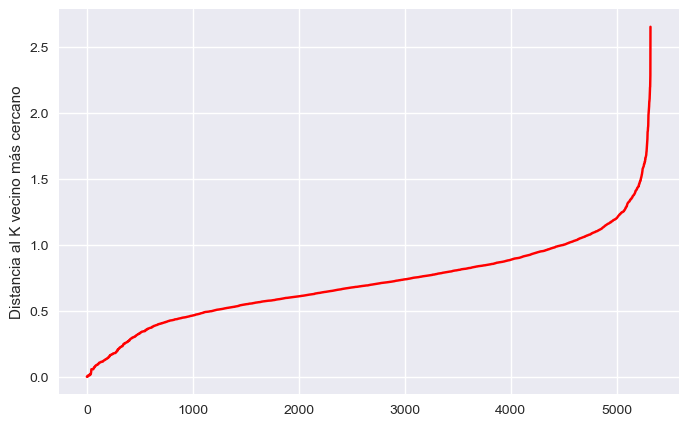

In [131]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 5))
plt.plot(distances, color = 'red')
plt.ylabel('Distancia al K vecino más cercano')
plt.show()

In [132]:
# --- Selección del punto de curvatura máxima ---
kl = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
kl.elbow

5220

In [133]:
# --- Epsilon óptimo --
epsilon = distances[kl.elbow]
epsilon

1.4791130191003434

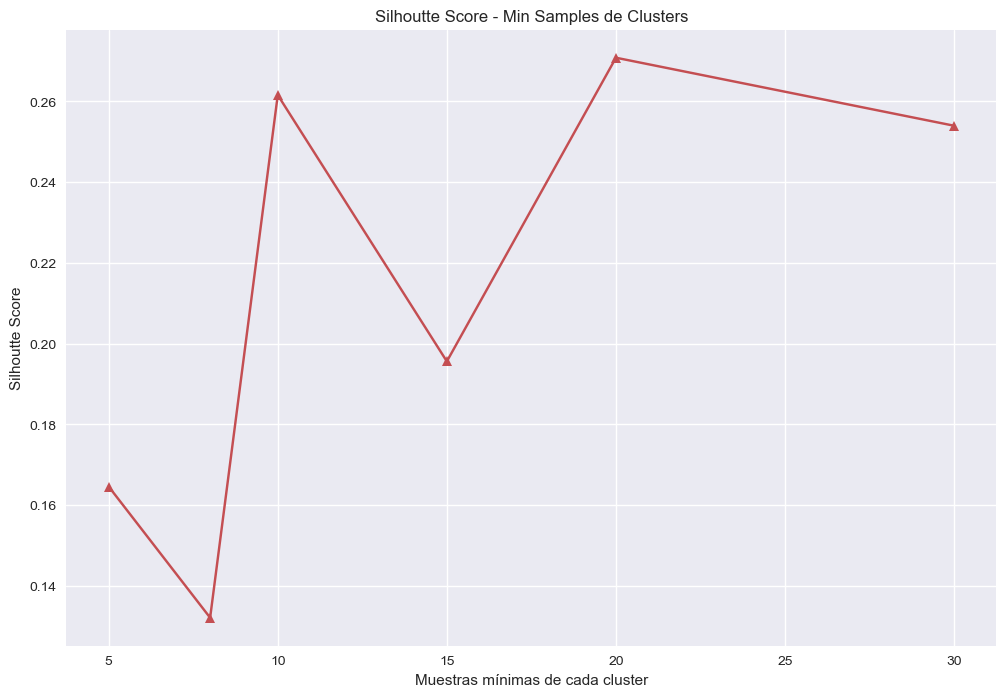

In [134]:
# --- Selección de hiperparámetros min_sample ---
silhoutte_coefs = []

for min_points in [5, 8, 10, 15, 20, 30]:
    model_d = DBSCAN(eps = epsilon, min_samples = min_points)
    model_d.fit(X_pca)
    silhoutte_coefs.append(silhouette_score(X_pca, model_d.labels_))

plt.figure(figsize = (12, 8))
plt.plot([5, 8, 10, 15, 20, 30], silhoutte_coefs, color = 'r', marker = '^')
plt.xlabel('Muestras mínimas de cada cluster')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score - Min Samples de Clusters')
plt.show()

In [136]:
# --- Modelo DBSCAN ---
model_db_pca = DBSCAN(eps = epsilon, min_samples = 20)
model_db_pca.fit(X_pca)

DBSCAN(eps=1.4791130191003434, min_samples=20)

In [137]:
# --- Evaluación del modelo DBSCAN ---
print(" ### DBSCAN ###")
print('Silhouette Score: ', silhouette_score(X_pca, model_db_pca.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, model_db_pca.labels_))

 ### DBSCAN ###
Silhouette Score:  0.27079459086082497
Calinski harabasz score:  1160.680776060073


In [138]:
# Predicción de los clusters
Cluster_5 = model_db_pca.fit_predict(X_pca)

df_final['Cluster_5']= Cluster_5
df_final.head(3)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.238055          2.298926    -2.273272       -0.724004   1.019157   
1       0.605077          2.298926    -2.273272       -0.559650   2.020762   
2       0.605077          2.298926    -1.985367       -0.630087   1.747597   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.114479             -1.417952  1.128801  1.812423   0.240980   
1            -0.287116             -0.833163  0.783878 -0.151665   1.156786   
2            -0.878090             -1.063534  0.852863  0.228481   0.927835   

    alcohol   quality     color  Cluster_1  Cluster_2  Cluster_3  Cluster_4  \
0 -0.969388 -0.937379 -1.707233          1          2          1          0   
1 -0.631951 -0.937379 -1.707233          1          2          1          0   
2 -0.631951 -0.937379 -1.707233          1          2          1          0   

   Cluster_5  
0          0  
1          0  
2          0

In [139]:
df_final['Cluster_5'].value_counts()

Cluster_5
 1    3635
 0    1242
-1     443
Name: count, dtype: int64

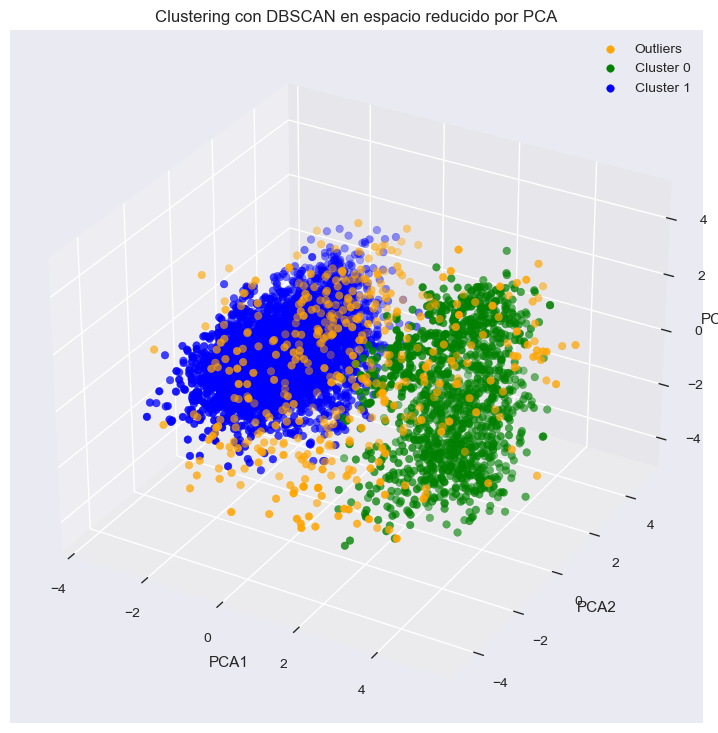

In [147]:
from mpl_toolkits.mplot3d import Axes3D

# Obtener las etiquetas de clúster asignadas por DBSCAN
labels = model_db_pca.labels_

# Obtener las coordenadas PCA reducidas (asumiendo X_pca tiene 3 componentes principales)
x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

# Crear una figura 3D
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

# Colorear los puntos por clúster
for label in np.unique(labels):
    if label == 0:
        # Pintar los puntos del cluster 0 en verde
        ax.scatter(x[labels == label], y[labels == label], z[labels == label], color='green', s=30, label='Cluster 0')
    elif label == 1:
        # Pintar los puntos del cluster 1 en azul
        ax.scatter(x[labels == label], y[labels == label], z[labels == label], color='blue', s=30, label='Cluster 1')
    else:
        # Pintar los outliers (cluster -1) en naranja
        ax.scatter(x[labels == label], y[labels == label], z[labels == label], color='orange', s=30, label='Outliers')

# Configurar etiquetas y título
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Clustering con DBSCAN en espacio reducido por PCA')

# Mostrar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

## Clustering Algorithm: Gaussian Mixture Model

### Dataset Original